This notebook goes through how to draw a **sphere in a sphere**.

# IMPORTS

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objects as go

from spomso.cores.helper_functions import generate_grid, smarter_reshape, hard_binarization
from spomso.cores.geom_3d import Sphere
from spomso.cores.geom_2d import Arc
from spomso.cores.combine import CombineGeometry

# PARAMETERS

In [2]:
# size of the volume
co_size = 2.3, 2.3, 2.3
# resolution of the volume
co_resolution = 150, 150, 150

show = "FIELD" # BINARY, FIELD
show_midplane = True
show_3d = False

# COORDINATE SYSTEM

Point cloud of coordinates is created with the **generate_grid** function, which takes the size of the coordinate system and the number of points in each direction (**co_resolution**).

In [3]:
coor, co_res_new = generate_grid(co_size, co_resolution)

If there is an even number of points along any direction the function will automatically convert it to an odd number, therefore the origin is always included in the point cloud. The point cloud is a numpy.ndarray with a shape of **(D, N)**, where **D** is the number of dimensions and **N** is the number of data points.

# CREATE SDFs

Create the **inner sphere** with a **radius** of **0.375**:

In [4]:
inner_sphere = Sphere(0.375)

Create a **2D Arc** which will become the **outer hollow sphere**. The **radius** of the **arc** is **0.75**, and the **angles** between which the **arc** spans are **-$\pi$/4** and **$\pi$/3**:

In [5]:
outer_sphere = Arc(0.75, -np.pi/4, np.pi/3)

Add **0.1** of thickness to the **arc**:

In [6]:
outer_sphere.rounding(0.1)

<function spomso.cores.modifications.ModifyObject.rounding.<locals>.new_geo_object(co, *params)>

**Revolve** the **arc** around the **y-axis** to create the **hollow sphere** with a cutout. The **radius** of **revolution** is set to **0**:

In [7]:
outer_sphere.revolution(0)

<function spomso.cores.modifications.ModifyObject.revolution.<locals>.new_geo_object(co, *params)>

Print the **modifications** and **transformations** applied to the **outer sphere**:

In [8]:
print("Outer sphere modifications:", outer_sphere.modifications)
print("Outer sphere transformations:", outer_sphere.transformations)

Outer sphere modifications: ['rounding', 'revolution']
Outer sphere transformations: []


**Combine** the **inner** and **outer** **sphere** into a single geometry:

In [9]:
union = CombineGeometry("UNION2")
combined = union.combine(inner_sphere, outer_sphere)

**Rotate** the **combined geometry** by **45°** around the **z-axis**:

In [10]:
combined.rotate(np.pi/4, (0,0,1))

**Rescale** the **combined geometry** by a factor of **1.25**. The new size of the geometry will be ***size* $\cdot$ 1.25**. The **radius** of the **inner sphere** will be **0.375 $\cdot$ 1.25**:

In [11]:
combined.rescale(1.25)

Print the **modifications** and **transformations** applied to the **combined** geometry:

In [12]:
print("Combined geometry modifications:", combined.modifications)
print("Combined geometry transformations:", combined.transformations)

Combined geometry modifications: []
Combined geometry transformations: ['rotate', 'rescale']


## EVALUATE

Evaluate the SDF of the **combined geometry** to create a signed distance field 3D map. This is done by calling the **create** method and passing in the point cloud of coordinates:

In [13]:
combined_pattern = combined.create(coor)

# BINARIZATION

Convert the distance field to a binary voxel map, where 1 corresponds to the interior and 0 to the exterior of the geometry.

In [14]:
if show_midplane:
    field = smarter_reshape(combined_pattern, co_resolution)
    if show=="BINARY":
        pattern_2d = hard_binarization(field, 0)

if show=="BINARY":
    pattern = hard_binarization(combined_pattern, 0)

# PLOT

Drawing results...


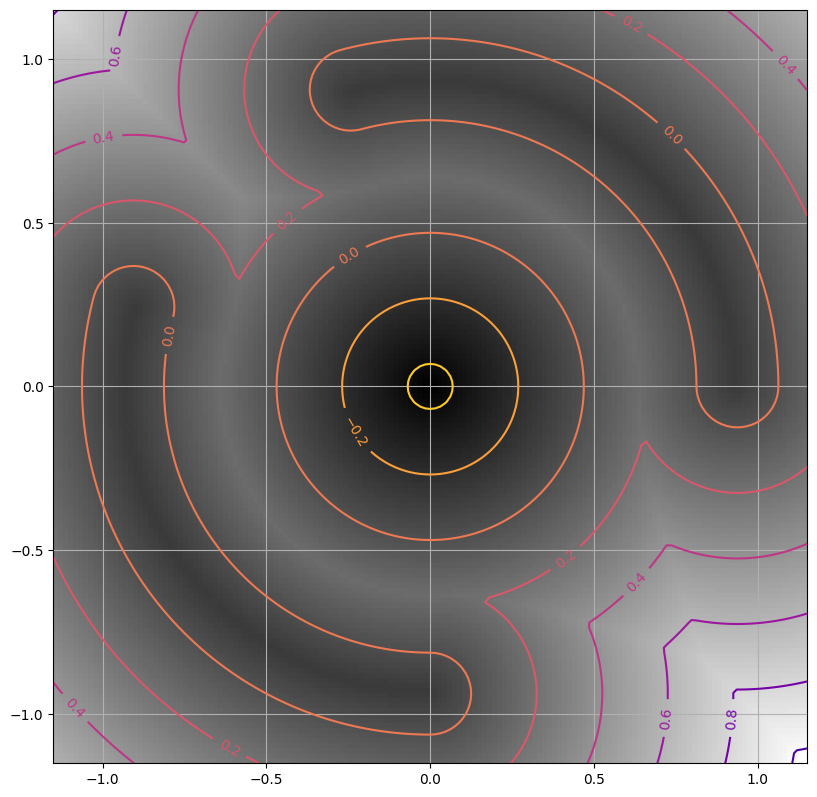

In [15]:
print("Drawing results...")
# Mid-plane cross-section plot
if show_midplane and show=="BINARY":
    fig, ax = plt.subplots(1,1, figsize=(8.25, 8.25))
    ax.imshow(pattern_2d[:, :, co_resolution[-1]//2].T,
              cmap="binary_r",
              extent=(-co_size[0]/2, co_size[0]/2,
                      -co_size[1]/2, co_size[1]/2),
              origin="lower"
              )
    ax.grid()

    fig.tight_layout()
    plt.show()

if show_midplane and show == "FIELD":
    fig, ax = plt.subplots(1, 1, figsize=(8.25, 8.25))
    ax.imshow(field[:, :, co_resolution[-1] // 2].T,
              cmap="binary_r",
              extent=(-co_size[0] / 2, co_size[0] / 2,
                      -co_size[1] / 2, co_size[1] / 2),
              origin="lower"
              )
    z_mask = coor[2] == 0
    cs = ax.contour(coor[0, z_mask].reshape(co_res_new[0], co_res_new[1]),
                    coor[1, z_mask].reshape(co_res_new[0], co_res_new[1]),
                    field[:, :, co_resolution[-1] // 2],
                    cmap="plasma_r")
    ax.clabel(cs, inline=True, fontsize=10)
    ax.grid()

    fig.tight_layout()
    plt.show()

In [16]:
# Isosurfaces plot
if show_3d and show=="BINARY":
    fig = go.Figure(data=go.Volume(
        x=coor[0],
        y=coor[1],
        z=coor[2],
        value=pattern,
        isomin=0.1,
        isomax=1,
        opacity=0.1,
        surface_count=2,
    ))
    fig.show()

if show_3d and show=="FIELD":
    fig = go.Figure(data=go.Volume(
        x=coor[0],
        y=coor[1],
        z=coor[2],
        value=combined_pattern,
        isomin=-0,
        isomax=0.5,
        opacity=0.1,
        surface_count=5,
    ))
    fig.show()
